<a href="https://colab.research.google.com/github/SheetMusic-Team-3/semantic-music-model/blob/main/first_inference_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# import top-level dependencies
import tensorflow as tf
import cv2
import numpy as np
import os
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from zipfile import ZipFile
import glob
from google.colab.patches import cv2_imshow

In [ ]:
# mount drive if not already mounted
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# copy modules to path
% env PATH_TO_TEAM_FOLDER=/content/drive/MyDrive
% cp -r $PATH_TO_TEAM_FOLDER/Team_3_cs121S21/'Work Products'/'Semantic Model Inference'/ .
% cd 'Semantic Model Inference'
% ls

env: PATH_TO_TEAM_FOLDER=/content/drive/MyDrive
cp: cannot open '/content/drive/MyDrive/Team_3_cs121S21/Work Products/Semantic Model Inference/test-set-output/test-alpha-69.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Team_3_cs121S21/Work Products/Semantic Model Inference/test-set-output/test-alpha-74.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Team_3_cs121S21/Work Products/Semantic Model Inference/test-set-output/test-alpha-79.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Team_3_cs121S21/Work Products/Semantic Model Inference/test-set-output/test-alpha-3.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/Team_3_cs121S21/Work Products/Semantic Model Inference/test-set-output/test-alpha-4.gdoc' for reading: Operation not supported
/content/Semantic Model Inference
ctc_utils.py                images/           test-set/
first-inference-test.ipy

In [ ]:
# import modules
import ctc_utils

In [ ]:
model_zip_path="./model-artifacts/Semantic-Model.zip"
# extract model files from zip
with ZipFile(model_zip_path, 'r') as zipObj:
   zipObj.extractall()

In [ ]:
voc_path="./model-artifacts/vocab.txt"
model_path="./semantic-model.meta"
image_folder = "./test-set"

In [ ]:
output_image_folder="./test-set-output"

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Read the dictionary
dict_file = open(voc_path,'r')
dict_list = dict_file.read().splitlines()
int2word = dict()
for word in dict_list:
    word_idx = len(int2word)
    int2word[word_idx] = word
dict_file.close()

# Restore weights
saver = tf.train.import_meta_graph("semantic_model.meta")
saver.restore(sess,"semantic_model.meta"[:-5])

graph = tf.get_default_graph()

input = graph.get_tensor_by_name("model_input:0")
seq_len = graph.get_tensor_by_name("seq_lengths:0")
rnn_keep_prob = graph.get_tensor_by_name("keep_prob:0")
height_tensor = graph.get_tensor_by_name("input_height:0")
width_reduction_tensor = graph.get_tensor_by_name("width_reduction:0")
logits = tf.get_collection("logits")[0]

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from semantic_model


#Single Test

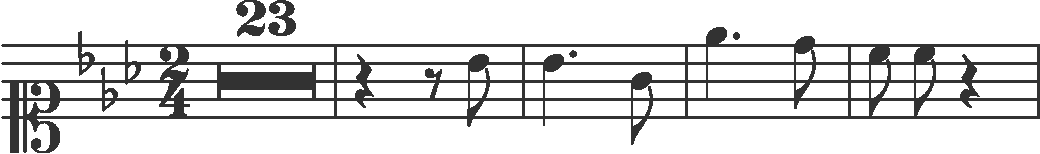

clef-C1
keySignature-EbM
timeSignature-2/4
multirest-23
barline
rest-quarter
rest-eighth
note-Bb4_eighth
barline
note-Bb4_quarter.
note-G4_eighth
barline
note-Eb5_quarter.
note-D5_eighth
barline
note-C5_eighth
note-C5_eighth
rest-quarter
barline


In [ ]:
file_name = "./images/test1.png"

WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

decoded, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)

image = cv2.imread(file_name,False)
#show image
cv2_imshow(image)
image = ctc_utils.resize(image, HEIGHT)
image = ctc_utils.normalize(image)
image = np.asarray(image).reshape(1,image.shape[0],image.shape[1],1)

seq_lengths = [ image.shape[2] / WIDTH_REDUCTION ]

prediction = sess.run(decoded,
                      feed_dict={
                          input: image,
                          seq_len: seq_lengths,
                          rnn_keep_prob: 1.0,
                      })

str_predictions = ctc_utils.sparse_tensor_to_strs(prediction)
for w in str_predictions[0]:
    print(int2word[w])


# Batch Inference

In [ ]:
# run batch inference
for image_path in glob.glob(f'{image_folder}/*.png'):

  # create text file
  file_name = image_path.split("/")[2][:-4]
  if not os.path.exists(output_image_folder):
    os.makedirs(output_image_folder)
  out_file= open(f'{output_image_folder}/{file_name}.txt',"w+")

  WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

  decoded, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)

  image = cv2.imread(image_path,False)
  image = ctc_utils.resize(image, HEIGHT)
  image = ctc_utils.normalize(image)
  image = np.asarray(image).reshape(1,image.shape[0],image.shape[1],1)

  seq_lengths = [ image.shape[2] / WIDTH_REDUCTION ]

  prediction = sess.run(decoded,
                        feed_dict={
                            input: image,
                            seq_len: seq_lengths,
                            rnn_keep_prob: 1.0,
                        })

  str_predictions = ctc_utils.sparse_tensor_to_strs(prediction)

  for w in str_predictions[0]:
      out_file.write(int2word[w])
      out_file.write('\n')